In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

from sentence_transformers import SentenceTransformer

In [2]:
def get_meta(body, attr):
    soup = BeautifulSoup(body, parser='html.parser')
    metatags = soup.findAll('meta')
    attr_ = [m.get(attr, None) for m in metatags]
    attr = [a.lower() for a in attr_ if a != None]
    
    return np.unique(attr)

In [3]:
url = 'http://cnn.com'
body = requests.get(url).text
soup = BeautifulSoup(body, 'lxml')

In [4]:
soup.findAll('meta')

[<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>,
 <meta charset="utf-8"/>,
 <meta content="text/html" http-equiv="Content-Type"/>,
 <meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0" name="viewport"/>,
 <meta content="intl_homepage" name="section"/>,
 <meta content="unsafe-url" name="referrer"/>,
 <meta content="2014-02-24T14:45:54Z" property="og:pubdate"/>,
 <meta content="2014-02-24T14:45:54Z" name="pubdate"/>,
 <meta content="2020-12-03T17:39:07Z" name="lastmod"/>,
 <meta content="https://edition.cnn.com" property="og:url"/>,
 <meta content="CNN International - Breaking News, US News, World News and Video" property="og:title"/>,
 <meta content="CNN International - Breaking News, US News, World News and Video" name="twitter:title"/>,
 <meta content="Find the latest breaking news and information on the top stories, weather, business, entertainment, politics, and more. For in-depth coverage, CNN provides special reports, video, audio, photo galler

In [11]:
df = pd.read_json('/dlabdata1/lugeon/websites_alexa_mostpop_html.json.gz', orient='records', lines=True)

In [12]:
df = df[(df.errcode==200) & (df.cat != 'World')]

In [13]:
df

,uid,url,html,errcode,cat
0,0,http://xvideos.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult
1,1,http://xnxx.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult
2,2,http://chaturbate.com,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",200.0,Adult
3,3,http://youporn.com,"<!DOCTYPE html>\n<html lang=""en"" class=""grid"">...",200.0,Adult
4,4,http://livejasmin.com,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",200.0,Adult
...,...,...,...,...,...
795,795,http://arsenal.com,"<!DOCTYPE html>\n<html lang=""en"" dir=""ltr"" pre...",200.0,Sports
796,796,http://sherdog.com,"<!DOCTYPE html><html version=""XHTML+RDFa 1.0"">...",200.0,Sports
797,797,http://hkjc.com,\r\n<!DOCTYPE html>\r\n<html>\r\n\t<head>\r\n\...,200.0,Sports
798,798,http://afl.com.au,"<html lang=""en"">\n<head>\n\t<meta charset=""UTF...",200.0,Sports


In [8]:
df['meta_name'] = df.apply(lambda row: get_meta(row.html, 'name'), axis=1)

In [9]:
df['meta_proprety'] = df.apply(lambda row: get_meta(row.html, 'property'), axis=1)

In [10]:
df.head()

,uid,url,html,errcode,cat,meta_name,meta_proprety
0,0,http://xvideos.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[]
1,1,http://xnxx.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[]
2,2,http://chaturbate.com,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",200.0,Adult,"[description, keywords, msapplication-tilecolo...","[og:description, og:image, og:image:height, og..."
3,3,http://youporn.com,"<!DOCTYPE html>\n<html lang=""en"" class=""grid"">...",200.0,Adult,"[adsbytrafficjunkycontext, application-name, d...",[]
4,4,http://livejasmin.com,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",200.0,Adult,"[category, description, google, issearchpage, ...","[og:description, og:image, og:site_name, og:ti..."


In [11]:
df.shape

(715, 7)

## Values of attributes *name* and *proprety*, and their presence in the various categories

In [12]:
cats = df.cat.unique()

def compute_attr_presence(attr, min_pres):
    all_meta_attr = [] 

    counts = []

    for cat in cats:
        df_cat = df[df.cat == cat]
        meta_attrs = df_cat[attr].values
        count = pd.Series([a for b in meta_attrs for a in b]).value_counts() / df_cat.shape[0]
        min_count = count[count >= min_pres]
        counts.append(count)
        all_meta_attr += min_count.index.tolist()
        #print(cat)
        #print(count, '\n')

    all_meta_attr = np.unique(all_meta_attr)
    
    count_array = np.zeros((len(all_meta_attr), len(cats)))
    
    for i in range(len(cats)):
        j = 0
        for attr in all_meta_attr:
            count_array[j,i] = counts[i].get(attr, 0)
            j += 1
        
    return count_array, all_meta_attr
    

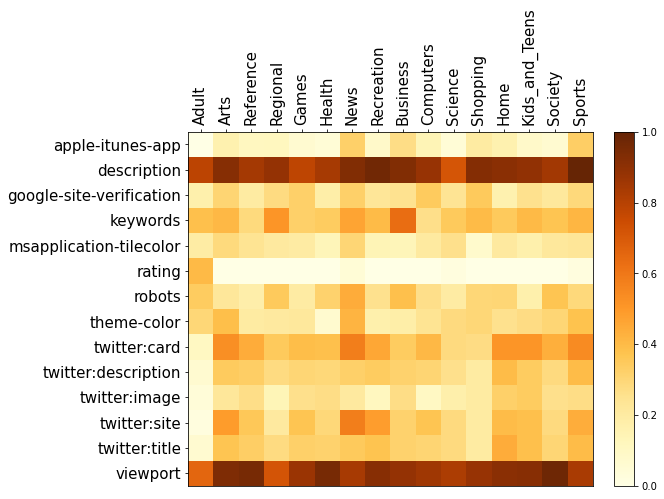

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

count_attr, attr_names = compute_attr_presence('meta_name', 0.3)

fig, ax = plt.subplots(figsize=(8, 12))

im = plt.imshow(count_attr, cmap='YlOrBr', interpolation='nearest', vmin=0, vmax=1)

plt.xticks(np.arange(len(cats)), cats, rotation=90, fontsize=15)
plt.yticks(np.arange(len(attr_names)), attr_names, fontsize=15)
ax.xaxis.tick_top()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

plt.colorbar(im, cax=cax)

#ax.title.set_text('Presence of the different kinds of "name" attribute w.r.t to categories')

plt.show()

In [14]:
count_attr, attr_names = compute_attr_presence('meta_name', 0.1)

std = []

for i in range(count_attr.shape[0]):
    std.append(np.std(count_attr[i]))
    
sorti = np.argsort(std)[::-1]

print('The presence-feature with the most variance are...')

for i in sorti[:15]:
    print("{:<18} {:.4f}".format(attr_names[i], std[i]))

The presence-feature with the most variance are...
twitter:site       0.1288
twitter:card       0.1177
rating             0.0972
apple-itunes-app   0.0970
theme-color        0.0864
keywords           0.0860
twitter:title      0.0843
viewport           0.0820
twitter:image      0.0810
robots             0.0776
twitter:description 0.0767
generator          0.0731
description        0.0710
application-name   0.0664
format-detection   0.0663


In [15]:
most_variant_attr = attr_names[sorti][:15]
most_variant_attr

array(['twitter:site', 'twitter:card', 'rating', 'apple-itunes-app',
       'theme-color', 'keywords', 'twitter:title', 'viewport',
       'twitter:image', 'robots', 'twitter:description', 'generator',
       'description', 'application-name', 'format-detection'],
      dtype='<U37')

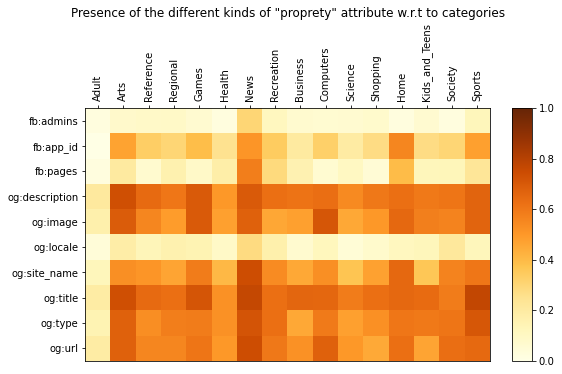

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

count_attr, attr_names = compute_attr_presence('meta_proprety', 0.2)

fig, ax = plt.subplots(figsize=(8, 12))

im = plt.imshow(count_attr, cmap='YlOrBr', interpolation='nearest', vmin=0, vmax=1)

plt.xticks(np.arange(len(cats)), cats, rotation=90)
plt.yticks(np.arange(len(attr_names)), attr_names)
ax.xaxis.tick_top()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

plt.colorbar(im, cax=cax)

ax.title.set_text('Presence of the different kinds of "proprety" attribute w.r.t to categories')

plt.show()

## Embedding of the *description*

In [17]:
def get_desc(body):
    soup = BeautifulSoup(body, 'html.parser')
    desc = soup.find('meta', attrs = {'name': ['description', 'Description']})
    if desc:
        return [s.strip() for s in desc["content"].split('.') if s]
    return None
    

In [18]:
get_desc(requests.get('http://facebook.com').text)

['Erstelle ein Konto oder melde dich bei Facebook an',
 'Verbinde dich mit Freunden, Familie und anderen Personen, die du kennst',
 'Teile Fotos und Videos,']

In [19]:
df['desc'] = df.apply(lambda row: get_desc(row.html), axis=1)

In [20]:
model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')

In [21]:
def encode_or_none(s):
    if s == None:
        return None
    else:
        return model.encode(s).mean(axis=0)

In [22]:
df['desc_emb'] = df.apply(lambda row: encode_or_none(row.desc), axis=1)

<ipython-input-21-e1af19ed9cdc>:5: RuntimeWarning: Mean of empty slice.
  return model.encode(s).mean(axis=0)
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
df.head()

,uid,url,html,errcode,cat,meta_name,meta_proprety,desc,desc_emb
0,0,http://xvideos.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[],[XVIDEOS Free Porn Videos],"[-0.14601764, 0.14098579, 0.011557743, -0.4463..."
1,1,http://xnxx.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[],[XNXX delivers free sex movies and fast free p...,"[0.13418701, 0.0436669, -0.066224284, -0.20475..."
2,2,http://chaturbate.com,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",200.0,Adult,"[description, keywords, msapplication-tilecolo...","[og:description, og:image, og:image:height, og...",[Watch Live Cams Now! No Registration Required...,"[-0.008984722, -0.01458589, -0.08052273, -0.43..."
3,3,http://youporn.com,"<!DOCTYPE html>\n<html lang=""en"" class=""grid"">...",200.0,Adult,"[adsbytrafficjunkycontext, application-name, d...",[],[YouPorn is your home for free XXX porn videos...,"[-0.06611139, 0.007593561, -0.019413913, -0.20..."
4,4,http://livejasmin.com,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",200.0,Adult,"[category, description, google, issearchpage, ...","[og:description, og:image, og:site_name, og:ti...",[Chat for FREE on LiveJasmin and watch HD Live...,"[0.038140766, -0.04423845, 0.092270374, -0.413..."


In [24]:
df_desc = df[df.desc_emb.notnull()]
df_desc.reset_index(inplace=True, drop=True)

In [90]:
x = np.concatenate(df_desc.desc_emb.to_numpy()).ravel()
x = x.reshape(-1, 768)
x.shape

(619, 768)

In [91]:
df_desc.desc_emb[:10]

0    [-0.14601764, 0.14098579, 0.011557743, -0.4463...
1    [0.13418701, 0.0436669, -0.066224284, -0.20475...
2    [-0.008984722, -0.01458589, -0.08052273, -0.43...
3    [-0.06611139, 0.007593561, -0.019413913, -0.20...
4    [0.038140766, -0.04423845, 0.092270374, -0.413...
5    [0.11699875, -0.08313185, 0.21621762, -0.28392...
6    [0.0086797215, -0.17944117, -0.054632418, -0.3...
7    [-0.06002807, 0.020701334, 0.16299927, -0.0874...
8    [0.026830917, 0.04650431, 0.0030741189, -0.085...
9    [0.025326766, -0.13555245, -0.088242106, -0.26...
Name: desc_emb, dtype: object

<ipython-input-112-6dd40158d949>:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
<ipython-input-112-6dd40158d949>:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


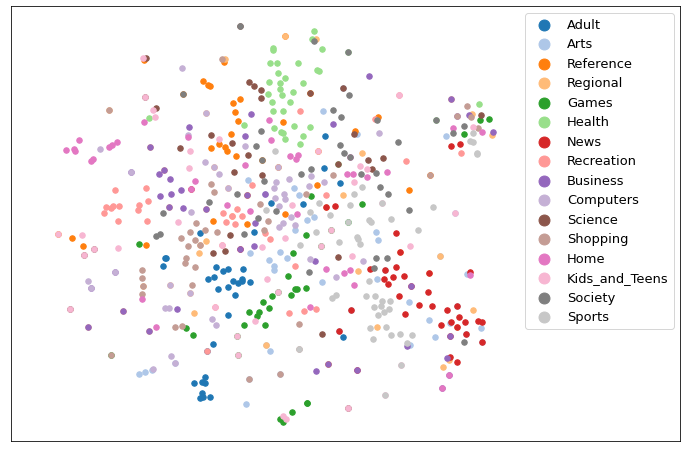

In [112]:
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

categories = df_desc.cat.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 30
marker = 'o'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_desc[df_desc.cat == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-45,65])
#ax.set_ylim([0,1])

ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

## Embedding of the *keywords*

In [28]:
def get_kw(body):
    soup = BeautifulSoup(body, 'html.parser')
    kw = soup.find('meta', attrs = {'name': 'keywords'})
    if kw:
        try:
            return [kw["content"]]
        except KeyError:
            pass
    return None

In [29]:
get_kw(requests.get('http://foxnews.com').text)

['news, breaking news, latest news, current news, world news, national news']

In [30]:
df['kw'] = df.apply(lambda row: get_kw(row.html), axis=1)

In [31]:
df['kw_emb'] = df.apply(lambda row: encode_or_none(row.kw), axis=1)

In [32]:
df_kw = df[df.kw_emb.notnull()]
df_kw.reset_index(inplace=True, drop=True)

In [88]:
x = np.concatenate(df_kw.kw_emb.to_numpy()).ravel()
x = x.reshape(-1, 768)
x.shape

(264, 768)

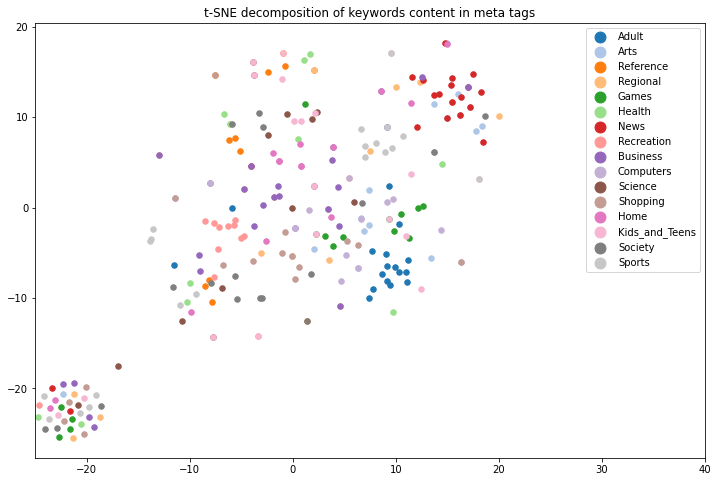

In [89]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

categories = df_desc.cat.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 30
marker = 'o'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_kw[df_kw.cat == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-25,40])
#ax.set_ylim([0,1])
    
plt.title('t-SNE decomposition of keywords content in meta tags')
plt.legend(markerscale=2)
plt.plot();

Almost clusters!

## Inspecting time-related meta-name for News category

In [35]:
df_cat = df[df.cat == 'News']
meta_attrs = df_cat['meta_name'].values
count = pd.Series([a for b in meta_attrs for a in b]).value_counts()

In [36]:
target = ['last', 'pub', 'date', 'mod']

In [37]:
news_spec = np.unique([m for m in count.index for t in target if t in m]).tolist()
news_spec

['date',
 'dc.date',
 'dc.date.created',
 'dc.publisher',
 'dcterms.datecopyrighted',
 'dcterms.modified',
 'last-modified',
 'last-modified-date',
 'last-modified-time',
 'lastmod',
 'minutely-publisher',
 'msvalidate.01',
 'pubdate',
 'publisher']

In [135]:
news_date_spec = ['dc.date.created',
'dc.publisher',
 'last-modified',
 'last-modified-date',
 'last-modified-time',
 'lastmod',
 'minutely-publisher',
 'msvalidate.01',
 'pubdate',
 'publisher']

# removed two terms with dcterms.blablalba...

In [133]:
cats = df.cat.unique()

v = []

for cat in cats:
    df_cat = df[df.cat == cat]
    mask = [len(set(news_date_spec).intersection(set(m.tolist()))) > 0 for m in df_cat.meta_name]
    v.append(sum(mask) / df_cat.shape[0])
    
np.std(v)

0.008725923088644574

In [134]:
mask = [len(set(news_date_spec).intersection(set(m.tolist()))) > 0 for m in df.meta_name]
df[mask].cat.value_counts()

Arts    1
Home    1
News    1
Name: cat, dtype: int64

The standard deviation of the grouped "time-related attributes" indicates that this also could be a valid feature

## Putting everything together

In [41]:
df_agg = df[df.desc_emb.notnull()]

In [42]:
def add_or_none(row):
    if type(row.kw_emb) == np.ndarray:
        return row.desc_emb + row.kw_emb
    else:
        return row.desc_emb 

In [43]:
df_agg['kw_desc_emb'] = df_agg.apply(add_or_none, axis=1)

<ipython-input-43-9a40c5279969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['kw_desc_emb'] = df_agg.apply(add_or_none, axis=1)


In [44]:
df_agg.head()

,uid,url,html,errcode,cat,meta_name,meta_proprety,desc,desc_emb,kw,kw_emb,kw_desc_emb
0,0,http://xvideos.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[],[XVIDEOS Free Porn Videos],"[-0.14601764, 0.14098579, 0.011557743, -0.4463...","[xvideos,xvideos.com, x videos,x video,porn,vi...","[-0.05813962, 0.21787325, 0.015402947, -0.0584...","[-0.20415726, 0.35885903, 0.02696069, -0.50479..."
1,1,http://xnxx.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[],[XNXX delivers free sex movies and fast free p...,"[0.13418701, 0.0436669, -0.066224284, -0.20475...","[porn,porn movies,free porn,free porn movies,s...","[-0.123688996, 0.20752415, -0.0052011064, -0.2...","[0.010498017, 0.25119105, -0.07142539, -0.4737..."
2,2,http://chaturbate.com,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",200.0,Adult,"[description, keywords, msapplication-tilecolo...","[og:description, og:image, og:image:height, og...",[Watch Live Cams Now! No Registration Required...,"[-0.008984722, -0.01458589, -0.08052273, -0.43...","[free cams, free adult video chat, free sex we...","[-0.122137934, 0.18165682, 0.05366501, -0.4386...","[-0.13112265, 0.16707093, -0.026857723, -0.868..."
3,3,http://youporn.com,"<!DOCTYPE html>\n<html lang=""en"" class=""grid"">...",200.0,Adult,"[adsbytrafficjunkycontext, application-name, d...",[],[YouPorn is your home for free XXX porn videos...,"[-0.06611139, 0.007593561, -0.019413913, -0.20...",None,None,"[-0.06611139, 0.007593561, -0.019413913, -0.20..."
4,4,http://livejasmin.com,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",200.0,Adult,"[category, description, google, issearchpage, ...","[og:description, og:image, og:site_name, og:ti...",[Chat for FREE on LiveJasmin and watch HD Live...,"[0.038140766, -0.04423845, 0.092270374, -0.413...","[live, gender, cams, cam, real, web, amateur, ...","[-0.027970636, 0.02459159, 0.011430742, -0.245...","[0.01017013, -0.019646859, 0.103701115, -0.658..."


In [45]:
df_agg['meta_name_emb'] = df_agg.apply(lambda row: [int(a in row.meta_name) for a in most_variant_attr], axis=1)

<ipython-input-45-32de4838deb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['meta_name_emb'] = df_agg.apply(lambda row: [int(a in row.meta_name) for a in most_variant_attr], axis=1)


In [46]:
df_agg['time_attr_emb'] = df_agg.apply(lambda row: int(len([a for n in news_date_spec for a in row['meta_name'] if a == n]) > 0) , axis=1)

<ipython-input-46-f0ec46c53d4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['time_attr_emb'] = df_agg.apply(lambda row: int(len([a for n in news_date_spec for a in row['meta_name'] if a == n]) > 0) , axis=1)


In [47]:
df_agg['full_name_emb'] = df_agg.apply(lambda row: row.meta_name_emb + [row.time_attr_emb], axis=1)

<ipython-input-47-8d1363ecf05a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['full_name_emb'] = df_agg.apply(lambda row: row.meta_name_emb + [row.time_attr_emb], axis=1)


In [48]:
df_agg.head(1)

,uid,url,html,errcode,cat,meta_name,meta_proprety,desc,desc_emb,kw,kw_emb,kw_desc_emb,meta_name_emb,time_attr_emb,full_name_emb
0,0,http://xvideos.com,"<!doctype html>\n<html class=""xv-responsive"" l...",200.0,Adult,"[description, format-detection, keywords, rati...",[],[XVIDEOS Free Porn Videos],"[-0.14601764, 0.14098579, 0.011557743, -0.4463...","[xvideos,xvideos.com, x videos,x video,porn,vi...","[-0.05813962, 0.21787325, 0.015402947, -0.0584...","[-0.20415726, 0.35885903, 0.02696069, -0.50479...","[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]",0,"[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]"


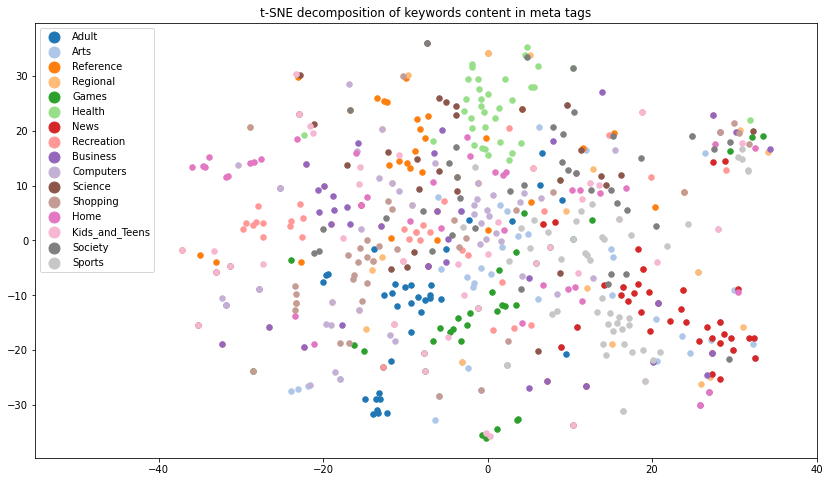

In [97]:
df_agg.reset_index(inplace=True, drop=True)
x = np.concatenate(df_agg.kw_desc_emb.to_numpy()).ravel()
x = x.reshape(-1, 768)

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

categories = df_desc.cat.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 30
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_agg[df_agg.cat == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-55,40])
#ax.set_ylim([0,1])

plt.title('t-SNE decomposition of keywords content in meta tags')
plt.legend(markerscale=2)
plt.plot();

Adding the keywords to the description doesn't really improve the clusters, the information in the keywords may be redondant with the information already in the description (e.g same words)

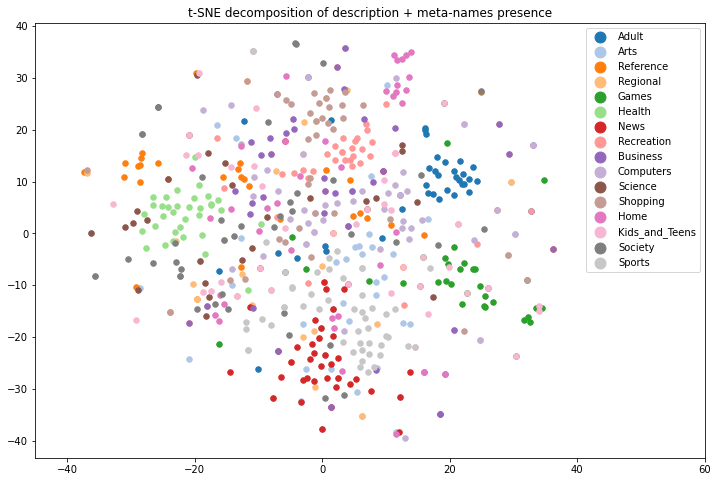

In [102]:
from sklearn.preprocessing import normalize

x_desc = np.concatenate(df_agg.desc_emb.to_numpy()).ravel().reshape(-1, 768)

x_names = np.concatenate(df_agg.full_name_emb.to_numpy()).ravel().reshape(-1, 16)

x_full = np.concatenate((x_desc, x_names), axis=1)
x_full_norm = normalize(x_full, axis=0)

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_full_norm)

categories = df_agg.cat.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 30
marker = 'o'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_agg[df_agg.cat == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-45,60])
#ax.set_ylim([0,1])
    
plt.title('t-SNE decomposition of description + meta-names presence')
plt.legend(markerscale=2)
plt.plot();

As if clusters were more reconizable, but hard to tell

In [138]:
df[df.cat == 'News']

,uid,url,html,errcode,cat,meta_name,meta_proprety,desc,desc_emb,kw,kw_emb
301,401,http://cnn.com,"<!DOCTYPE html><html class=""no-js""><head><meta...",200.0,News,"[description, keywords, lastmod, pubdate, refe...","[fb:app_id, fb:pages, og:description, og:pubda...",[Find the latest breaking news and information...,"[0.05463076, -0.115279794, -0.021884818, 0.219...","[breaking news, news online, U.S. news, world ...","[0.07668236, 0.08707754, 0.07488214, 0.2393939..."
302,402,http://news.google.com,"<!doctype html><html lang=""en"" dir=""ltr""><head...",200.0,News,"[apple-itunes-app, apple-mobile-web-app-capabl...","[og:description, og:image, og:image:height, og...","[Comprehensive up-to-date news coverage, aggre...","[0.042763993, -0.15314756, 0.20327859, -0.0528...",None,None
303,403,http://nytimes.com,"<!DOCTYPE html>\n<html lang=""en"" xmlns:og=""ht...",200.0,News,"[application-name, cg, description, keywords, ...","[fb:app_id, og:description, og:image, og:title...","[Live news, investigations, opinion, photos an...","[0.027615584, -0.09540923, 0.27004397, 0.09393...","[news, live updates, latest news, breaking new...","[0.10261285, -0.081334464, 0.10582178, 0.18373..."
304,404,http://indiatimes.com,"<!doctype html><html lang=""en""><head><title da...",200.0,News,"[description, google-site-verification, msappl...","[fb:app_id, fb:pages, og:description, og:image...","[Indiatimes, com brings you the news, articles...","[-0.015393503, 0.009364881, 0.223068, -0.17000...",None,None
305,405,http://shutterstock.com,"<!DOCTYPE html><html lang=""en"" class=""no-js"" d...",200.0,News,"[apple-itunes-app, description, google-site-ve...","[description, og:description, og:image, og:sit...",[Download the best royalty free images from Sh...,"[0.03366962, 0.3036318, 0.12352188, -0.2435743...",None,None
306,406,http://theguardian.com,"\n<!DOCTYPE html>\n<html id=""js-context"" class...",200.0,News,"[apple-mobile-web-app-title, application-name,...","[al:ios:app_name, al:ios:app_store_id, al:ios:...","[Latest international news, sport and comment ...","[-0.04433052, -0.19661677, 0.38723966, 0.01809...",None,None
307,407,http://washingtonpost.com,"<!DOCTYPE html><html lang=""en""><head><meta htt...",200.0,News,"[audio_url, description, external, keywords, m...","[fb:admins, fb:app_id, og:description, og:imag...","[Breaking news and analysis on politics, busin...","[0.028368255, -0.0004745815, 0.20969395, 0.258...",[],"[0.18770182, -0.31837517, 0.6503673, -0.046908..."
308,408,http://news.yahoo.com,"<!DOCTYPE html><html id=""atomic"" class=""NoJs d...",200.0,News,"[apple-itunes-app, application-name, descripti...","[fb:app_id, fb:pages, og:description, og:image...",[The latest news and headlines from Yahoo! New...,"[0.18077806, -0.21433915, 0.109997064, -0.0412...",None,None
309,409,http://foxnews.com,"<!DOCTYPE html><html lang=""en""><head><meta cha...",200.0,News,"[apple-itunes-app, apple-mobile-web-app-capabl...","[fb:pages, og:description, og:image, og:site_n...","[Breaking News, Latest News and Current News f...","[0.046627063, -0.13437973, 0.16410914, -0.0388...","[news, breaking news, latest news, current new...","[0.043595374, -0.0015108647, 0.20693666, 0.221..."
310,410,http://weather.com,"<!doctype html><html dir=""ltr"" lang=""de-CH""><h...",200.0,News,"[description, msapplication-tilecolor, msappli...","[og:description, og:image, og:image:secure_url...","[Wettervorhersage, Witterungsbedingungen und D...","[-0.03214953, 0.008435646, 0.09209535, -0.1385...",None,None
